
### OBJECTIVE

Detect patients sex chromosomes from single cell metaphase chromosomes.

### BACKGROUND

### DATA

**Source:** https://www.cellimagelibrary.org/pages/auto_chromosome_detector

Total metaphase images: <number>

Train: 
- male:
- female:
- monosomy X:

Validation: 
- normal male:
- normal female:
- monosomy X:

Test: 
- normal male:
- normal female:
- monosomy X:

The input data are pictures of human single cell G-banded metaphase chromosomes in JPG format. All images are named using the scheme image_id_sexchromosomes.jpg. Variable "image_id" is a 6-digit unique identifier according to original dataset. Variable "sexchromosomes" is sex chromosomes labeled by the author (Kadi Jairus) according to International System for Human Cytogenetic Nomenclature (XX, XY or X).

### METHOD

- TensorFlow is used to develop and train a Convolutional Neural Network (CNN) architecture aimed at classifying images.
- Different CNN architectures were tested to identify the most effective structure for our classification task.
- Data augmentation techniques were applied including random rotations, flips, and brightness adjustments are applied to increase the robustness of the model and improve generalization.
- A systematic search was conducted for the optimal set of hyperparameters, including learning rate, batch size, and number of epochs.
- Various optimizers were tested such as Adam, SGD, and RMSprop to find the best algorithm for minimizing the loss function.
- A validation strategy was implemented to monitor the model's performance on unseen data during training.

In [1]:
"""Imports modules and creates directory for files."""


import datetime
import os
import shutil
import pathlib
"""
from functools import partial
"""
import numpy as np
import matplotlib as mpl
"""
from mpl_toolkits.axes_grid1 import ImageGrid
"""

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pytz

# Makes directory for current training
tallinn_tz = pytz.timezone('Europe/Tallinn')
today = datetime.now(tallinn_tz).strftime("%Y-%m-%d_%H-%M")
report_dir = f'{today}_Chromo_cnn_model_training'

try:
    os.makedirs(report_dir, exist_ok=True)
    print(f"Directory '{report_dir}' created successfully.")
except PermissionError:
    print(f"Permission denied: Could not create directory '{report_dir}'.")


Directory '2024-12-24_20-43_Chromo_cnn_model_training' created successfully.


In [2]:
"""Sets up the environment and imports necessary libraries for TensorFlow and Keras."""


# Suppress tensorflow info messages
%env TF_CPP_MIN_LOG_LEVEL=2
%env TF_NUM_INTEROP_THREADS=8

# Set segmentation_models framework to the correct keras
%env SM_FRAMEWORK=tf.keras

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall

# Use mixed_float16, which is a good speedup on HPC cluster GPUs
tf.keras.config.set_dtype_policy("mixed_float16")

try: 
    tf_version = tf.__version__
    keras_version = tf.keras.__version__
    print(f"Setup succesful!\nTensorflow version {tf_version}. \nKeras version: {keras_version}")
except Exception as e:
    print(f"Setup failed :( {e}")

env: TF_CPP_MIN_LOG_LEVEL=2
env: TF_NUM_INTEROP_THREADS=8
env: SM_FRAMEWORK=tf.keras
Setup succesful!
Tensorflow version 2.16.1. 
Keras version: 3.7.0


Note: I'm sticking to tensorflow==2.16.1 because newer versions are basically broken on our system

Temp Fix from: https://github.com/tensorflow/tensorflow/issues/62075#issuecomment-2387257399

In [3]:
"""Optional code block. Checks the number of GPUs."""


num_gpus = len(tf.config.list_physical_devices('GPU'))
if num_gpus == 0:
    raise SystemError('No GPU devices found')
else:
    print(f"{num_gpus} gpu(s) found")

1 gpu(s) found


In [4]:
"""Specifies the location of data. Creates directories for models and logs."""


# Uncomment below to download data into localstorage
#!bash download_data.sh "/localstorage/$USER/isic_data"

data_dir = pathlib.Path("data")
if not data_dir.exists():
    raise ValueError("The specified data directory does not exist.")
    
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

logs_path = f"{report_dir}/logs"
models_path = "models"

try:
    os.makedirs(logs_path, exist_ok=True)
    os.makedirs(models_path, exist_ok=True) 
    print(f"Directories for logs and models created successfully in {report_dir}.")
except PermissionError as e:
    print(f"Permission denied: Could not create needed directories. {e}")

Directories for logs and models created successfully in 2024-12-24_20-43_Chromo_cnn_model_training.


In [5]:
"""Option 1. Defines the CNN model."""


def create_cnn(num_classes):
    """
    Define model architecture.
    :param int: height, width, channels
    :param int: number of classes
    :return: model
    """
    model = Sequential()
    # Convolutional layer with ReLU activation. 32 (pow of two) filters. 3x3 filter size. Input shape is picture resolution.
    
    # Define the input shape with an Input layer
    model.add(Input(shape=input_shape))  # Define the input shape here
    
    model.add(Conv2D(32, (4, 4), activation='relu', input_shape=input_shape))
    # Max pooling layer
    model.add(MaxPooling2D((2, 2)))
    # Additional convolutional layer
    model.add(Conv2D(64, (4, 4), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # Additional convolutional layer
    model.add(Conv2D(64, (4, 4), activation='relu'))
   
    # Flatten the output and add dense layers
    model.add(Flatten())
    # 64 is number of neurons.
    model.add(Dense(64, activation='relu'))
    # Output layer with softmax activation
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
"""Option 2. Defines the pre-trained Xception model."""


from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D


def create_xception(input_shape, num_classes):
    """
    Define model architecture.
    
    :param int: height, width, channels
    :param int: number of classes
    :return: model
    """
    # Load Xception base without top layers
    base_model = Xception(
        include_top=False,
        weights="imagenet",
        input_shape=(input_shape)
    )
    
    # Only train last layers
    base_model.trainable = False
    
    # Add custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    return model


In [6]:
IMG_SIZE = (300, 300)
INPUT_SHAPE = (300, 300, 3)
#IMG_SIZE = (224, 224) # Original image size for ResNet images

In [7]:
"""Specifies variables, compiles model and creates summary."""


# Adjustable parameters. Specified based on input pictures and classes.
input_shape = INPUT_SHAPE
num_classes = 3
# Uses 'adam' or 'sgd' optimizer
selected_optimizer = "adam"

#model = create_xception(input_shape, num_classes)
model = create_cnn(num_classes)

# Compiles the model 'adam' or 'sgd' optimizer
model.compile(optimizer=selected_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Saves model summary in table format
summary_file = f"{report_dir}/{today}_Model_architecture_summary_optimizer_{selected_optimizer}.txt"
with open(summary_file, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
# Shows the model
model.summary()

# Shows model as a graph
tf.keras.utils.plot_model(
    model,
    to_file=f"{report_dir}/{today}_Model_graph_optimizer_{selected_optimizer}.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=60,
)

/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 145, 145, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 69, 69, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 304704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    19,501,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,601,315 (74.77 MB)

 Trainable params: 19,601,315 (74.77 MB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [8]:
"""Defines how picture data will be generated."""


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a training image data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values: 0 to 1, not to 255.
    rotation_range=20,  # Random rotations, 20 degrees.
    width_shift_range=None,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shearing (darkness)
    zoom_range=0.2,  # Zooming
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'
)

# Defines a testing/validation image data generator with NO augmentation, only rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
"""Optional code block. Remove checkpoints if 4 classes instead of 3."""


def remove_ipynb_checkpoints(directory):
    for root, dirs, files in os.walk(directory):
        if '.ipynb_checkpoints' in dirs:
            checkpoint_path = os.path.join(root, '.ipynb_checkpoints')
            shutil.rmtree(checkpoint_path)
            print(f"Removed {checkpoint_path}")

# Apply to train, val, and test directories
remove_ipynb_checkpoints(train_dir)
remove_ipynb_checkpoints(val_dir)
remove_ipynb_checkpoints(test_dir)

Removed data/train/female/.ipynb_checkpoints


In [10]:
"""Generates training, validation and testing data."""


batch_size = 32
target_size=IMG_SIZE

# Changes parameters after each batch
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Loads images from the testing directory
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Matching the class_mode of the training data
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure the generator does not shuffle the images
)

print("Class indices for training data:", train_generator.class_indices)
print("Class indices for validation data:", val_generator.class_indices)
print("Class indices for testing data:", test_generator.class_indices)

Found 493 images belonging to 3 classes.
Found 109 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Class indices for training data: {'female': 0, 'male': 1, 'monosomy': 2}
Class indices for validation data: {'female': 0, 'male': 1, 'monosomy': 2}
Class indices for testing data: {'female': 0, 'male': 1, 'monosomy': 2}


/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1735065971.210345 4182383 service.cc:145] XLA service 0x7fe70400b260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735065971.210409 4182383 service.cc:153]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-12-24 20:46:20.179918: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[64,4,4,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,148,148,32]{3,2,1,0}, f16[32,145,145,64]{3,2,1,0}), window={size=4x4}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-24 20:46:22.617501: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.437677169s
Trying algorithm eng0{} for conv (f16[64,4,

 1/15 ━━━━━━━━━━━━━━━━━━━━ 3:43 16s/step - accuracy: 0.1250 - loss: 1.1271 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1735065984.802086 4182383 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/15 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step - accuracy: 0.3903 - loss: 3.9449 - precision: 0.4426 - recall: 0.3597

/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 951ms/step - accuracy: 0.3970 - loss: 3.9597 - precision: 0.4439 - recall: 0.3705 - val_accuracy: 0.4167 - val_loss: 1.1211 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4688 - loss: 1.1076 - precision: 0.0000e+00 - recall: 0.0000e+00

/opt/miniforge/envs/ogun/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4688 - loss: 1.1076 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 1.0183 - val_precision: 0.4167 - val_recall: 0.4167
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.4238 - loss: 1.0399 - precision: 0.4758 - recall: 0.1925 - val_accuracy: 0.5208 - val_loss: 0.9141 - val_precision: 0.5208 - val_recall: 0.5208
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6250 - loss: 0.8693 - precision: 0.6250 - recall: 0.6250 - val_accuracy: 0.5208 - val_loss: 0.9132 - val_precision: 0.5208 - val_recall: 0.5208
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - accuracy: 0.4862 - loss: 1.0364 - precision: 0.4559 - recall: 0.2303 - val_accuracy: 0.4167 - val_loss: 0.9324 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1875 - loss: 1.1164 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5208 - va

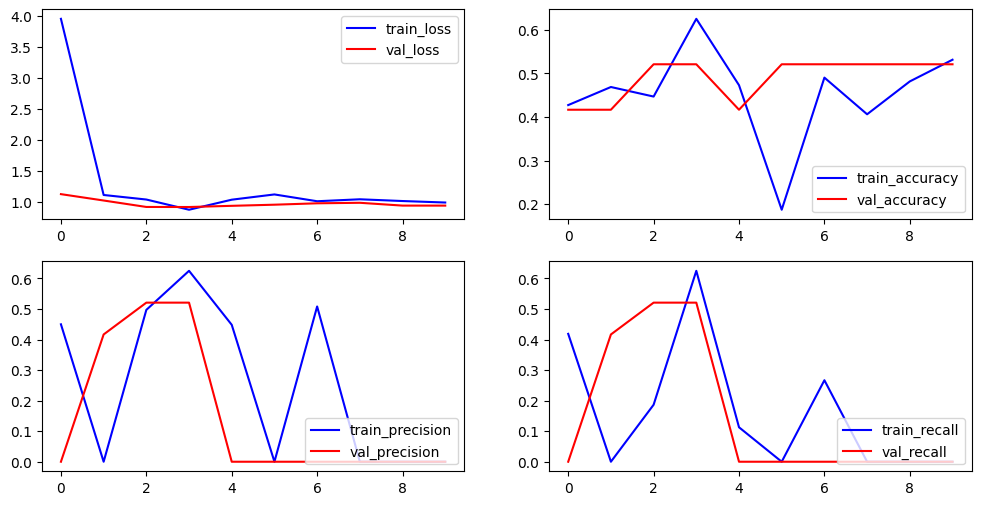

In [11]:
"""Trains and tests the model and writes results and model to file."""


#import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
#from sklearn.metrics import classification_report

number_of_epochs = 10

# Fit the model to the training data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Ensures the model sees the x_train samples per epoch
                                                                            # allows you to control how much data the model
                                                                            # should consume before declaring one epoch complete and moving on to the next epoch.
    epochs=number_of_epochs,  # Number of epochs to train for
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

keys = model.history.history.keys()
print(f"Model history keys are: \n{keys}")


# Generate plots
f,ax=plt.subplots(2,2, figsize=(12,6))
try:
  #1st subplot: training loss and validation loss
  ax[0, 0].plot(model.history.history['loss'],color='b',label='train_loss')
  ax[0, 0].plot(model.history.history['val_loss'],color='r',label='val_loss')
  ax[0, 0].legend(loc="upper right")
except Exception as e:
    print(f'Creating plot 0,0 failed: {e}')

try:
  #2nd subplot: training accuracy and validation accuracy
  ax[0, 1].plot(model.history.history['accuracy'],color='b',label='train_accuracy')
  ax[0, 1].plot(model.history.history['val_accuracy'],color='r',label='val_accuracy')
  ax[0, 1].legend(loc="lower right")
except Exception as e:
    print(f'Creating plot 0,1 failed: {e}')

try:
  #3rd subplot: training precision and validation precision
  ax[1, 0].plot(model.history.history['precision'],color='b',label='train_precision')
  ax[1, 0].plot(model.history.history['val_precision'],color='r',label='val_precision')
  ax[1, 0].legend(loc="lower right")
except Exception as e:
    print(f'Creating plot 1,0 failed: {e}')

try:
  #4th subplot: training recall and validation recall
  ax[1, 1].plot(model.history.history['recall'],color='b',label='train_recall')
  ax[1, 1].plot(model.history.history['val_recall'],color='r',label='val_recall')
  ax[1, 1].legend(loc="lower right")
except Exception as e:
    print(f'Creating plot 1,1 failed: {e}')


# Save plots to drive
filename = f"{report_dir}/{today}_CNN_training_plot_{number_of_epochs}_epochs_{batch_size}_batches_optimizer_{selected_optimizer}.png"
try:
    plt.savefig(filename)
    print('Saved figure')
except Exception as e:
    print(f'Saving figure to first location failed: {e}')
    try:
      plt.savefig(f'/content/drive/MyDrive/{filename}')
      print('Saved figure')
    except Exception as e:
      print(f'Saving figure failed: {e}')

# Saves model
save_path = f"models/{today}_Cyto_cnn_model_{number_of_epochs}_epochs_{batch_size}_batches_optimizer_{selected_optimizer}_img_300_px.keras"
model.save(save_path)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Accuracy: 0.5
Precision: 0.0000
Recall: 0.0000
Confusion Matrix:
[[ 0 34  0]
 [ 0 44  0]
 [ 0 10  0]]


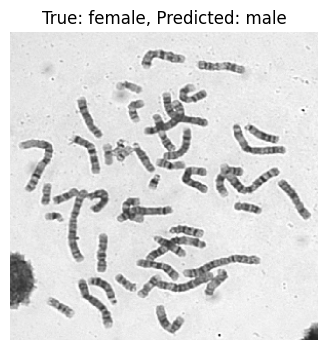

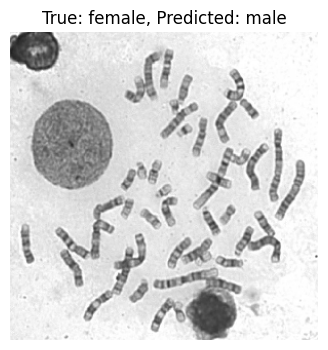

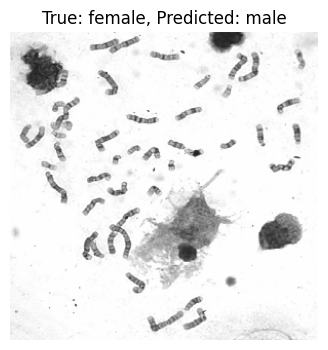

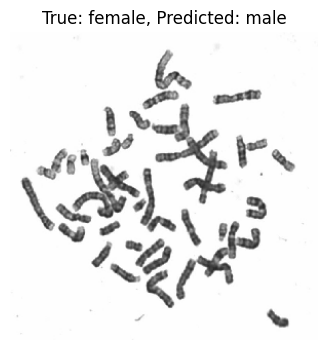

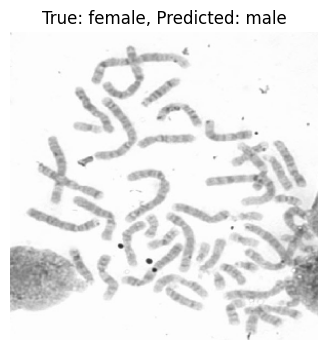

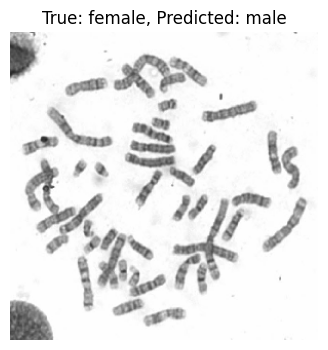

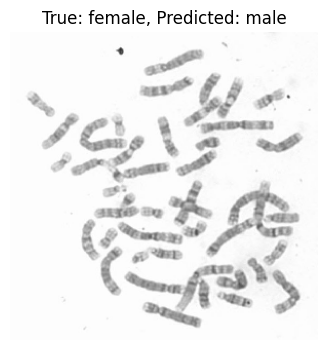

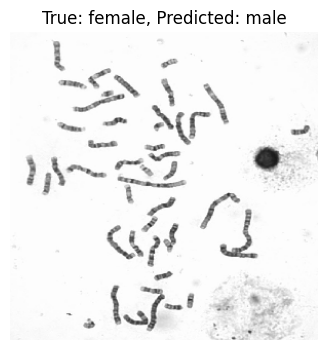

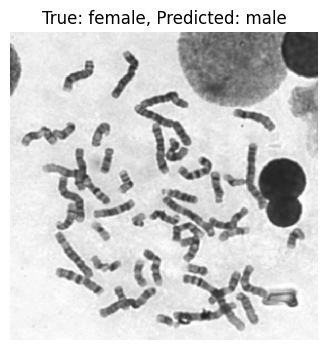

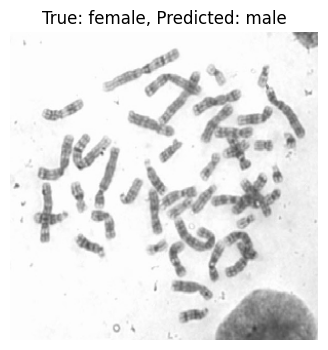

In [14]:
""" Test model"""


import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall

# Predictions and true labels
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Keras metrics
accuracy_metric = Accuracy()
accuracy_metric.update_state(true_labels, predicted_classes)
accuracy = accuracy_metric.result().numpy()

# Generate a confusion matrix manually
conf_matrix = np.zeros((len(class_labels), len(class_labels)), dtype=int)
for true, pred in zip(true_labels, predicted_classes):
    conf_matrix[true, pred] += 1

# Calculate precision and recall for each class
precision_metric = Precision()
recall_metric = Recall()

precision_metric.update_state(to_categorical(true_labels, num_classes=len(class_labels)), predictions)
recall_metric.update_state(to_categorical(true_labels, num_classes=len(class_labels)), predictions)

precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Save the report
filename = f"{report_dir}/{today}_classification_report_batch_{batch_size}_optimizer_sgd.txt"
try:
    os.makedirs(report_dir, exist_ok=True)
    with open(filename, 'w') as f:
        f.write("Classification Report\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write("\nConfusion Matrix:\n")
        for row in conf_matrix:
            f.write(' '.join(map(str, row)) + '\n')
except Exception as e:
    print(f"Error saving report: {e}")

# Plot incorrect predictions
incorrect_indices = np.where(predicted_classes != true_labels)[0]

# Reset generator
test_generator.reset()

# Visualize incorrect predictions
num_samples_to_plot = 10
plotted_count = 0

for i in range(len(test_generator)):
    images, labels = next(test_generator)

    # Check batch size
    if len(images) == 0:
        continue

    batch_start_index = i * test_generator.batch_size
    batch_end_index = batch_start_index + len(labels)

    batch_incorrect_indices = [idx for idx in incorrect_indices
                               if batch_start_index <= idx < batch_end_index]
    batch_relative_indices = [idx - batch_start_index for idx in batch_incorrect_indices]

    for idx in batch_relative_indices:
        if plotted_count >= num_samples_to_plot:
            break

        plt.figure(figsize=(4, 4))
        plt.imshow((images[idx] * 255).astype("uint8"))
        true_class = class_labels[true_labels[batch_start_index + idx]]
        predicted_class = class_labels[predicted_classes[batch_start_index + idx]]

        plt.title(f"True: {true_class}, Predicted: {predicted_class}")
        plt.axis('off')

        plot_filename = f"{report_dir}/Wrong_prediction_{plotted_count + 1}_{true_class}_predicted_{predicted_class}.png"
        plt.savefig(plot_filename, format='png')
        plt.show()

        plotted_count += 1

    if plotted_count >= num_samples_to_plot:
        break


In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices(to_tensor_slices(train_images_masks))
val_dataset = tf.data.Dataset.from_tensor_slices(to_tensor_slices(val_images_masks))
test_dataset = tf.data.Dataset.from_tensor_slices(to_tensor_slices(test_images_masks))

In [23]:
take = 5
images, masks = list(zip(
    *train_dataset
    .map(partial(load_images, resize_size = IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment_image)
    .map(partial(set_shapes, image_size = IMG_SIZE))
    .take(take)
))
images[0].shape, masks[0].shape

(TensorShape([512, 512, 3]), TensorShape([512, 512, 1]))

In [24]:
def serial_load_all_images():
    images, masks = [], []
    for k, v in train_images_masks.items():
        image, mask = load_images((str(v["image_path"]), str(v["mask_path"])), IMG_SIZE)
        images.append(image)
        masks.append(mask)
        #break
    return tf.stack(images), tf.stack(masks)

#%time train_images, train_masks = serial_load_all_images()
#train_images.shape, train_masks.shape

In [25]:
#%time all_train_images, all_train_masks = train_dataset.map(wrap_call(IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(train_dataset.cardinality(), num_parallel_calls=tf.data.AUTOTUNE).get_single_element()
#all_train_images.shape, all_train_masks.shape

[keras.image_dataset_from_directory](https://keras.io/api/data_loading/image/#image_dataset_from_directory-function) also available but it is for classification datasets

In [26]:
mpl.rcParams["figure.figsize"]

[6.4, 4.8]

In [27]:
mpl.rcParams["image.cmap"] = "gray"

In [28]:
def plotImages(images):
    l = len(images)
    cols = min(5, l)  # Up to 5 columns max
    rows = -(-l // cols)  # Compute the number of rows, rounding up

    # Create a figure with dynamic size
    fig = plt.figure(figsize=(3.5 * cols, 3.5 * rows))
    
    # Create an ImageGrid with variable dimensions
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.5)
    
    # Populate the grid with images
    for ax, img in zip(grid, images):
        ax.axis("off")
        ax.imshow(tf.cast(img, tf.int32), cmap='gray')  # Adjust depending on image format
    
    # Turn off remaining axes
    for ax in grid[len(images):]:
        ax.axis("off")
    
    plt.show()

def combine_images_and_masks(images, masks):
    combined = images[:5]  # Start with the first 5 images

    # Alternate between masks and images
    for i in range(5, len(images)):
        combined.append(masks[i])
        combined.append(images[i])
    
    return combined

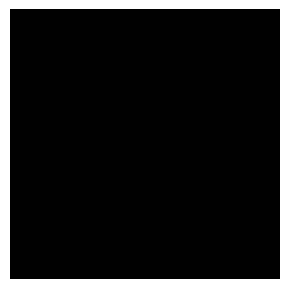

In [29]:
plotImages(images[:1])

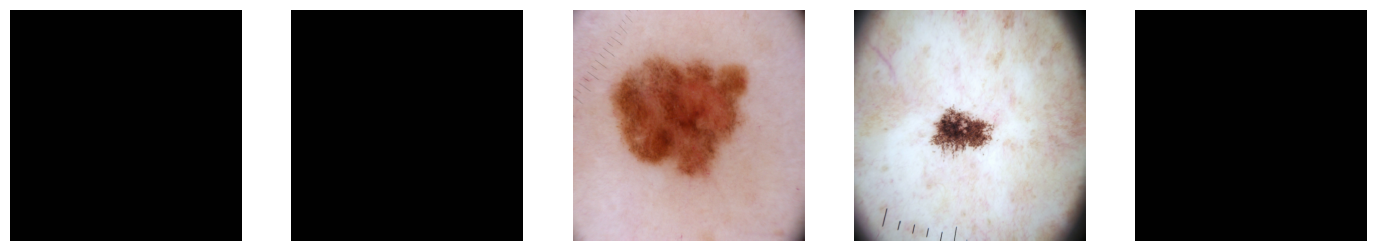

In [30]:
plotImages(images)

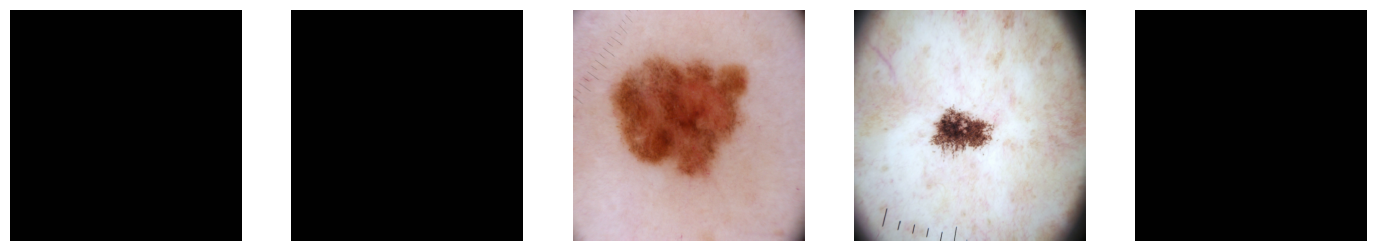

In [31]:
plotImages(combine_images_and_masks(images, masks))

In [32]:
BACKBONE = 'resnet34'
#BACKBONE = "vgg16"
preprocess_input = sm.get_preprocessing(BACKBONE)
#rescale = tf.keras.layers.Rescaling(1./255.)
#normalizer = tf.keras.layers.Normalization()
#%time normalizer.adapt(train_dataset.map(partial(load_images, resize_size = IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).map(lambda x, y: x))
#prep_layers = tf.keras.Sequential([rescale, normalizer])
#preprocess_input = lambda x, y: (normalizer(rescale(x)), rescale(y))
preprocess_input = lambda x, y : (x / 255.0, y / 255.0)

Note that the resnet34 preprocessing doesn't actually do anything so I just replace with a rescaling function

In [33]:
batch_size = 64
# This should use arguments but ... 
def prepare_dataset(ds, augment = False):
    loaded = ds.map(partial(load_images, resize_size = IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
    if augment :
        # Don't cache at all
        processed =  (
            loaded
            .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
            .map(partial(set_shapes, image_size=IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE)
        )
    else:
        processed = loaded.cache()
    return (
        processed
        .map(preprocess_input)
        .prefetch(tf.data.AUTOTUNE)
        .batch(batch_size,num_parallel_calls=tf.data.AUTOTUNE)
    )

train_ds = prepare_dataset(train_dataset, True)
val_ds = prepare_dataset(val_dataset)
test_ds = prepare_dataset(test_dataset)

In [36]:
images, masks = train_ds.take(1).get_single_element()
images.shape, masks.shape

(TensorShape([64, 512, 512, 3]), TensorShape([64, 512, 512, 1]))

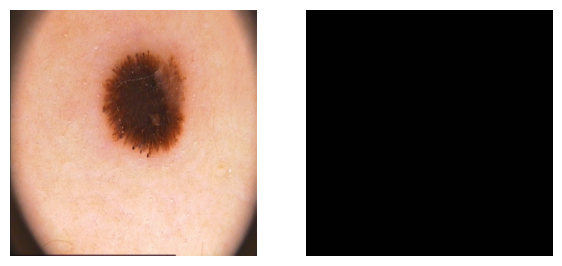

In [37]:
plotImages(combine_images_and_masks(images[:2] * 255, masks[:2]))

In [38]:
num_train_batches = train_ds.cardinality().numpy()
num_train_batches

14

 You might want to enable scrolling for outputs in the right click menu, the next cell's output is long

In [48]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
#model = sm.FPN(BACKBONE, encoder_weights='imagenet', encoder_freeze=True)
# learning rate
lr = 1e-6
# Lion is analogue of Adam
optimizer = tf.keras.optimizers.Adam(lr, weight_decay = 1e-2)
metrics=[sm.metrics.iou_score, sm.metrics.f1_score, sm.metrics.recall, sm.metrics.precision]
metrics=[tf.keras.metrics.BinaryIoU(name="jaccard")]
#lossfn = sm.losses.bce_jaccard_loss
lossfn = tf.keras.losses.Dice()
model.compile(
    optimizer = optimizer,
    loss=lossfn,
    metrics = metrics,
    jit_compile=False,
)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, None,      │          0 │ data[0][0]        │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ cast_2[0][0]      │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_68   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_6… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_69   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_6… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_70   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_71   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_7

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 3,167,060 (12.08 MB)

 Non-trainable params: 21,289,094 (81.21 MB)

In [49]:
tf.keras.utils.plot_model(model)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [50]:
train_pred = model.predict(images)
train_pred.shape, tf.reduce_min(train_pred).numpy(), tf.reduce_max(train_pred).numpy()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


((64, 512, 512, 1), 0.4124, 0.703)

In [51]:
lossfn(train_pred, masks).numpy()

0.59866965

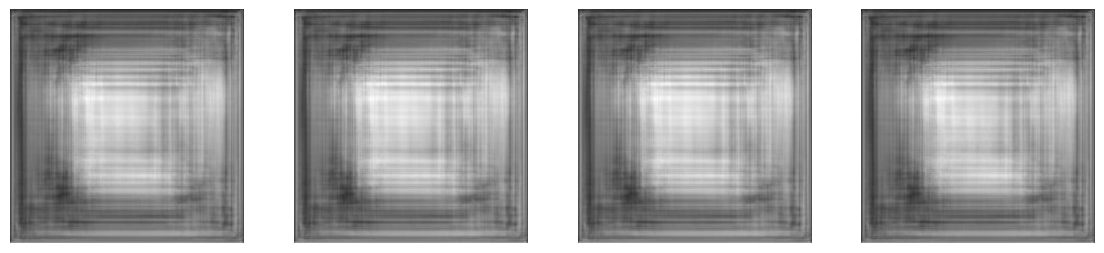

In [52]:
plotImages(train_pred[:4] * 255)

In [53]:
original_test_eval = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - jaccard: 0.1785 - loss: 0.6059


In [54]:
def timestamp():
    return datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

In [55]:
t = timestamp()
stub = f"lesion_{BACKBONE}_lr{lr}_{t}"
logs = logs_path / stub
print("Timestamp is", t)
print("logs at", logs)
epochs=40
cb_tb =  tf.keras.callbacks.TensorBoard(
    logs,
    #histogram_freq=1,
    #profile_batch=(num_train_batches + 2, num_train_batches + (num_train_batches + 2))
)
bk = BokehPlot()
bk.is_notebook = True # Had to read the source to figure out why it wasn't plotting
livelossesCB = PlotLossesCallback()
logging_cb = cb_tb
#logging_cb = livelossesCB
hist = model.fit(
    # Repeat ds
    # Stop training if not getting better / NaN
    train_ds,
    epochs=epochs,
    verbose=1,
    validation_data=val_ds,
    callbacks=[
        logging_cb,
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5, verbose=1)
    ]
)
save_path = models_path / f"{stub}.keras"
model.save(save_path)

Timestamp is 2024-11-28T15:20:11
logs at logs/lesion_resnet34_lr1e-06_2024-11-28T15:20:11
Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 947ms/step - jaccard: 0.2993 - loss: 0.6584 - val_jaccard: 0.2776 - val_loss: 0.6273
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.3161 - loss: 0.6502 - val_jaccard: 0.2427 - val_loss: 0.7088
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.3232 - loss: 0.6470 - val_jaccard: 0.2314 - val_loss: 0.6980
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.3406 - loss: 0.6420 - val_jaccard: 0.2199 - val_loss: 0.6949
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.3747 - loss: 0.6316 - val_jaccard: 0.3447 - val_loss: 0.6409
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.3895 - loss: 0.6256 - val_jaccard: 0.3451 - val_loss: 0.6662
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - jaccard: 0.4046 - loss: 0.6212 - val_jaccard: 0.3794 - val_loss: 0.6846
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [ ]:
train_model = tf.keras.models.load_model(save_path, compile=False)

In [ ]:
train_model.compile(loss = lossfn, metrics=metrics, jit_compile=True)

In [ ]:
prediction_metrics = train_model.evaluate(test_ds)
prediction_metrics

In [ ]:
predictions = train_model.predict(test_ds)

In [ ]:
predictions.shape, tf.reduce_max(predictions).numpy()

In [ ]:
plotImages(predictions[:4])